In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, Flatten, Dense, Activation, Add, BatchNormalization, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
#from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from tensorflow.keras.regularizers import l2 


In [2]:
class Residual(tf.keras.Model):
  def __init__(self, num_filters, use_1x1=False, strides=1):
    super(Residual, self).__init__()
    self.conv1 = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')
    self.batchnorm = BatchNormalization()
    self.activation = Activation('relu')
    self.conv2 = Conv2D(num_filters, kernel_size=3, strides=1, padding='same')
    if use_1x1:
      self.conv3 = Conv2D(num_filters, kernel_size=1, strides=strides, padding='valid')
    else: 
      self.conv3 = None
    
  def call(self, x):
    shortcut = x
    x = self.conv1(x)
    x = self.batchnorm(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.batchnorm(x)
    if self.conv3:
      shortcut = self.conv3(shortcut)
    return self.activation(x + shortcut)

In [3]:
optim = {}
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
optim['adam'] = adam

train_path = '../input/cassava-train/cassava_train/'
df = pd.read_csv('../input/cassava/train_data.csv')
#df.head()

df.label = df.label.astype('str')

In [4]:
size = 512
batch_size = 64
epochs = 25

In [5]:
def resnet_18():
  input_img = Input(shape=(size, size, 3)) 
  x = ZeroPadding2D(padding=(3, 3))(input_img)

  # First stage
  x = Conv2D(64, kernel_size=7, strides=2)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides=2)(x)
  # Second stage
  x = Residual(64)(x)
  x = Residual(64)(x)

  # Third stage
  x = Residual(128, use_1x1=True, strides=2)(x)
  x = Residual(128)(x)

  # Forth stage
  x = Residual(256, use_1x1=True, strides=2)(x)
  x = Residual(256)(x)

  # Fifth stage
  x = Residual(512, use_1x1=True, strides=2)(x)
  x = Residual(512)(x)

  # Final stage
  x = GlobalAveragePooling2D()(x)
  x = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)
  
  # define the model 
  model = Model(inputs=input_img, outputs=x, name='Resnet18')
  return model

In [6]:
traingen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2,                                      
                                     rotation_range = 15,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)
validgen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

In [7]:
train_gen = traingen.flow_from_dataframe(df, directory=train_path, 
                                       subset='training',
                                       x_col='image_id',
                                       y_col = "label",
                                       target_size = (size, size),
                                       batch_size = batch_size,
                                       shuffle=True,
                                       class_mode = "sparse")
valid_gen = validgen.flow_from_dataframe(df, directory=train_path, 
                                       subset='validation',
                                       x_col='image_id',
                                       y_col = "label",
                                       target_size = (size, size),
                                       batch_size = batch_size,
                                       shuffle=False,
                                       class_mode = "sparse")

Found 16947 validated image filenames belonging to 5 classes.
Found 4236 validated image filenames belonging to 5 classes.


In [8]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 2, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)

In [9]:
history = {}
def train_model():
    model = resnet_18()
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                  metrics=['accuracy'])
    model_save = ModelCheckpoint('./resnet18_cassava.h5',
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = 'val_loss', 
                                 mode = 'min', verbose = 1)
    milestone = model.fit(train_gen,
              validation_data=valid_gen,
              epochs=epochs,
              steps_per_epoch=train_gen.n//train_gen.batch_size,
              validation_steps = valid_gen.n//valid_gen.batch_size,
              callbacks = [early_stop, reduce_lr]
              )
    history['adam'] = milestone


In [10]:
# Training model
train_model()

Model: "Resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 518, 518, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
residual (Residual)          (None, 127, 127, 64)      741

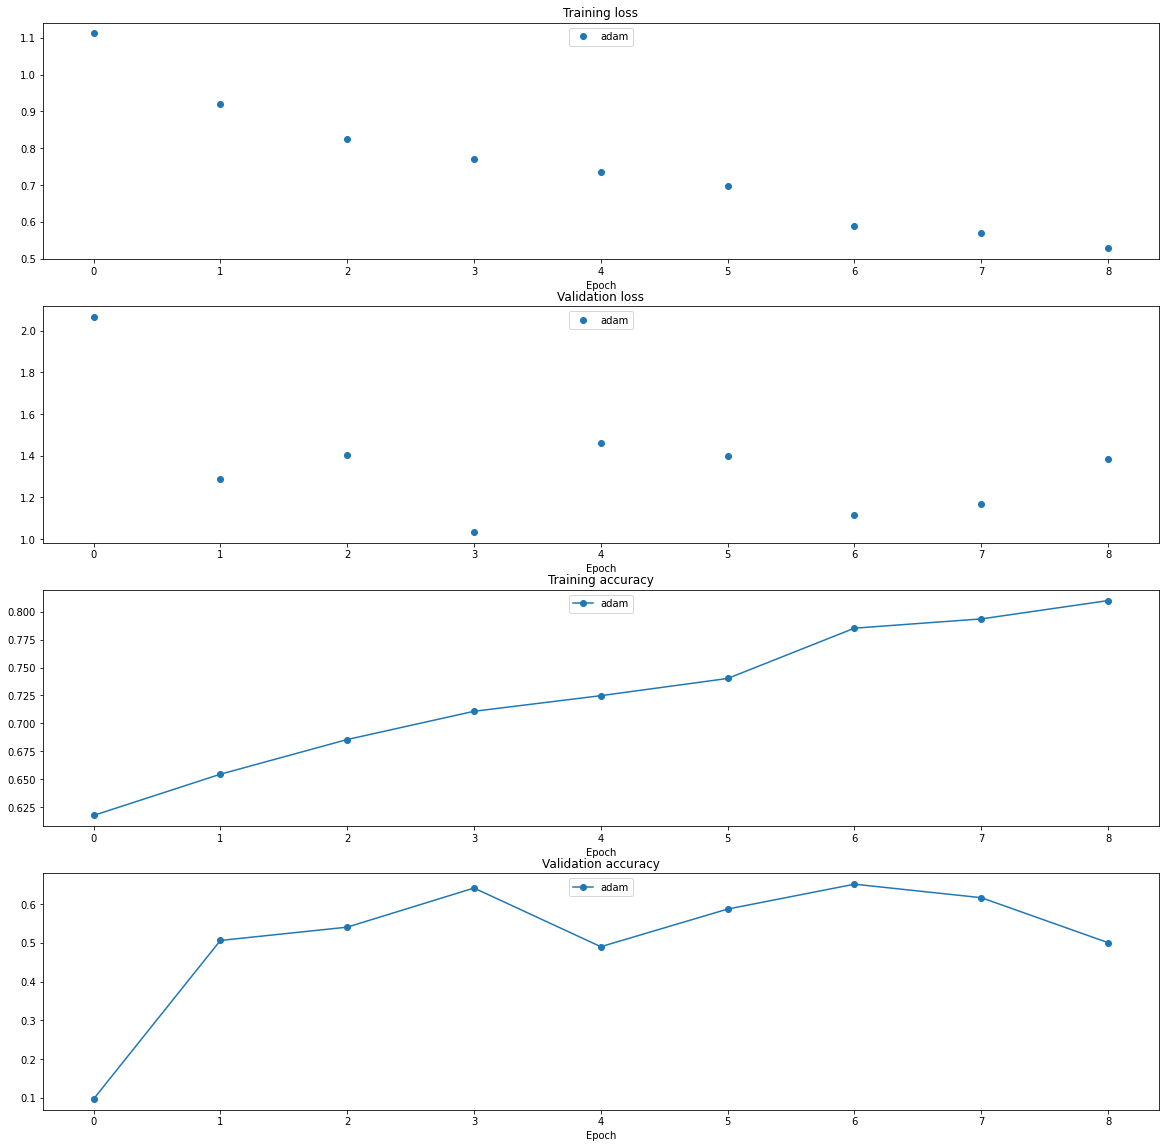

In [11]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()